# Create media designs using ART

We use ART to provide suggested designs for media components for which to get phenotypic data.  We will use absorbance at 340nm as assay for this experiment.

For DBTL 8 we create X designs from an exploratory mode with $\alpha=1.$ and relative recommendations distance X%, X designs from the exploitation mode ($\alpha=0$) and relative recommendations distance X%, and 1 design being close to the standard media as a control, totalling 16 designs in triplicates.


Tested using **ART Prod** kernel on skynet.ese.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds_extended.csv`
- `standard_recipe_concentrations_extended.csv`
- EDD study slug(s)

**File generated by running this notebook**
- 
-
-

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import os
import sys
# sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../../media_compiler')
import re
import warnings
import pickle
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warning_utils
warning_utils.filter_end_user_warnings()


In [2]:
from art.core import RecommendationEngine 
import art.plot as plot
import art.utility as utils
import edd_utils as eddu
from core import designs_pairwise

## User parameters

In [3]:
CYCLE = 8

user_params = {
    'bounds_file': f'../data/Putida_media_bounds_extended.csv',
    'output_file_path': f'../data/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../data/standard_recipe_concentrations_extended.csv',
    'study_slug_1': 'combinatorial-media-for-flaviolin-dbtl1-ed1e',
    'study_slug_2': 'combinatorial-media-for-flaviolin-dbtl-2',
    'study_slug_3': 'combinatorial-media-for-flaviolin-dbtl-3',
    'study_slug_4': 'combinatorial-media-for-flaviolin-dbtl-4',
    'study_slug_5': 'combinatorial-media-for-flaviolin-dbtl-5',
    'study_slug_6': 'combinatorial-media-for-flaviolin-dbtl-6',
    'study_slug_7': 'combinatorial-media-for-flaviolin-dbtl-7',
    'edd_server': 'edd.jbei.org',
    'username': 'tradivojevic',
}

In [4]:
os.makedirs(user_params['output_file_path'], exist_ok=True) 

### Defining media components and the number of instances (designs) to be created

Specify which components to explore:

In [5]:
user_params['components'] = [
    'H3BO3[mM]',
    'Glucose[mM]',
    'K2SO4[mM]',
    'K2HPO4[mM]',
    'FeSO4[mM]',
    'NH4Cl[mM]',
    'MgCl2[mM]',
    'NaCl[mM]',
    '(NH4)6Mo7O24[mM]',
    'CoCl2[mM]',
    'CuSO4[mM]',
    'MnSO4[mM]',
    'ZnSO4[mM]',
    'CaCl2[mM]'    
]

user_params['response_intermed'] = 'OD340'
user_params['response'] = 'OD340_yield'

Here we specify how many instances (designs) we want to create and how many replicates:

In [6]:
user_params['n_instances_explor'] = 7
user_params['n_instances_exploit'] = 8
user_params['n_replicates'] = 3

## Load the data

In [7]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [8]:
df_stand

,Concentration,Solubility
Component,,
MOPS[mM],40.00000,2389.37
Tricine[mM],4.00000,500.08
H3BO3[mM],0.00400,763.38
Glucose[mM],20.00000,5045.63
K2SO4[mM],0.29000,688.47
K2HPO4[mM],1.32000,9185.90
FeSO4[mM],0.01000,1438.75
NH4Cl[mM],9.52000,5290.71
MgCl2[mM],0.52000,11558.70


In [20]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']
study_slug_4 = user_params['study_slug_4']
study_slug_5 = user_params['study_slug_5']
study_slug_6 = user_params['study_slug_6']
study_slug_7 = user_params['study_slug_7']

edd_server = user_params['edd_server']
username = user_params['username']

In [21]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


In [22]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
    df_4 = eddu.export_study(session, study_slug_4, edd_server=edd_server)
    df_5 = eddu.export_study(session, study_slug_5, edd_server=edd_server)
    df_6 = eddu.export_study(session, study_slug_6, edd_server=edd_server)
    df_7 = eddu.export_study(session, study_slug_7, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')


100%|██████████| 96/96 [00:00<00:00, 3029.97it/s]


## Preprocess the data

Concatenate the six studies:

In [23]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])

In [11]:
df.head(2)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,148494,Combinatorial media for flaviolin DBTL1,148495,73b42c69-2d7f-486d-a8c4-b0be76916247,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148543,C1_WA1_A4-R1,NaN,Optical Density,0,NaN,0.4422,48.0
1,148494,Combinatorial media for flaviolin DBTL1,148496,938f921b-52c3-4aa6-bfef-d869fd71ac18,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148544,C1_WA1_A4-R2,NaN,Optical Density,0,NaN,0.3405,48.0


In [12]:
df_7.head(2)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,173217,Combinatorial media for flaviolin DBTL 7,173218,d7341daf-8208-4880-948a-9592fe69baa3,C7_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,173266,C7_WA1_C1-R1,NaN,OD340,0,NaN,0.0309,48.0
1,173217,Combinatorial media for flaviolin DBTL 7,173219,7fe64521-5051-4904-a562-05e7cacc7f15,C7_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,173267,C7_WA1_C1-R2,NaN,OD340,0,NaN,0.0222,48.0


Drop unnecessary columns:

In [24]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.rename(columns={'Protocol': 'Measurement Type'}, inplace=True)
df.head(2)

,Line Name,Line Description,Protocol,Value
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4422
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3405
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3397
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3602
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.2699


In [14]:
df_7 = df_7.loc[:,['Line Name','Line Description','Measurement Type','Value']]
df_7.head(2)

,Line Name,Line Description,Measurement Type,Value
0,C7_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.0309
1,C7_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.0222


Pivot the dataframe to include columns for all protocols:

In [25]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Measurement Type", values="Value")
df.reset_index(inplace=True)
df.head()

Protocol,Line Name,Line Description,OD340,OD600
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.4422,2.019
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3405,0.516
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3397,0.436
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3602,0.623
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.2699,0.699


DBTL 7 only has OD340 measurements.

In [16]:
df_7.rename(columns={'Value': 'OD340'}, inplace=True)
df_7.drop(columns='Measurement Type', inplace=True)
df_7.head()

,Line Name,Line Description,OD340
0,C7_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.0309
1,C7_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.0222
2,C7_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.0154
3,C7_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.0035
4,C7_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.0000


### Adding media information to the data frame

Add columns for each component:

In [26]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None
    
components = re.split(': |, ', df_7['Line Description'][0])[::2]
for comp in components:
    df_7[comp] = None


And assign values for each component and line:

In [27]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (4+c)] = float(value)

df.drop(columns='Line Description', inplace=True)
df.tail()

Protocol,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
283,C6_WD7_F7-R2,0.3230,0.621,40.0,4.0,0.034219,20.0,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867
284,C6_WD7_F7-R3,0.3304,0.424,40.0,4.0,0.034219,20.0,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867
285,C6_WD8_F8-R1,0.2993,1.064,40.0,4.0,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103
286,C6_WD8_F8-R2,0.3000,0.980,40.0,4.0,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103
287,C6_WD8_F8-R3,0.2958,1.275,40.0,4.0,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103


In [19]:
for i in range(len(df_7)):
    values = re.split(': |, ', df_7['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df_7.iloc[i, (3+c)] = float(value)

df_7.drop(columns='Line Description', inplace=True)
df_7.tail()

,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM]
43,C7_WA8_C8-R2,0.0330,40.0,4.0,0.023089,191.921217,0.129778,10.082546,0.048329,25.802273,1.886212,1672.460716,0.000485,0.002339,0.001446,0.014888,0.001487,0.005696
44,C7_WA8_C8-R3,0.0233,40.0,4.0,0.023089,191.921217,0.129778,10.082546,0.048329,25.802273,1.886212,1672.460716,0.000485,0.002339,0.001446,0.014888,0.001487,0.005696
45,C7_WD8_F8-R1,0.2638,40.0,4.0,0.003686,20.699982,0.279631,1.33523,0.009901,9.359875,0.471481,52.92838,0.000029,0.000285,0.000095,0.000746,0.000094,0.0
46,C7_WD8_F8-R2,0.2765,40.0,4.0,0.003686,20.699982,0.279631,1.33523,0.009901,9.359875,0.471481,52.92838,0.000029,0.000285,0.000095,0.000746,0.000094,0.0
47,C7_WD8_F8-R3,0.3008,40.0,4.0,0.003686,20.699982,0.279631,1.33523,0.009901,9.359875,0.471481,52.92838,0.000029,0.000285,0.000095,0.000746,0.000094,0.0


### Include units into column names to match the new format from DBTL 7

In [28]:
comp = df.columns.drop(['Line Name', 'OD340', 'OD600'])
comp_units = [f'{col}[mM]' for col in comp]
col_rename = dict(zip(comp, comp_units))

df.rename(columns=col_rename, inplace=True)


### Include CaCl2 value into all previous cycles

In [29]:
df["CaCl2[mM]"] = 0

In [22]:
df.head(1)

Measurement Type,Line Name,OD340,OD600,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM]
0,C1_WA1_A4-R1,0.4422,2.019,40.0,4.0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0


Append the DBTL 7 data

In [23]:
df = pd.concat([df, df_7])
df.reset_index(drop=True, inplace=True)

Include the Yield column:

In [28]:
df['OD340_yield'] = df['OD340'] / df['Glucose[mM]']
df['OD340_yield'] = pd.to_numeric(df['OD340_yield'])

Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In other DBTL cycles the control is stored in the last column (D8, E8, F8).

In [29]:
control_lines = df[df['Line Name'].str.find('WF5_F8') > 0]

control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [34]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
df_stacked.head()

,Line Name,Measurement Type,Value
0,C1_WA1_A4-R1,OD340,0.4422
1,C1_WA1_A4-R1,OD600,2.019
2,C1_WA1_A4-R1,MOPS[mM],40.0
3,C1_WA1_A4-R1,Tricine[mM],4.0
4,C1_WA1_A4-R1,H3BO3[mM],0.003744


## Media designs recommendations

### Generate ART suggested media

**Train ART on all previous data (DBTL 1-7)**

Define a dictionary that contains the settings that ART will use to generate a predictive model:

In [35]:
art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds': utils.read_table(user_params['bounds_file']), # file with bounds# input variables, i.e. features
    'seed': 10,                                           # seed for number random generator
    'cross_val': True,
    'recommend': False,
    'output_dir': user_params['output_file_path'],  # directory to store this output
    'scale_input_vars': True,
    'verbose': 1,
    'num_tpot_models': 4,
    'max_mcmc_cores': 10
}

Workaround until Issue #270 is fixed:

In [36]:
# art_params['bounds'] = art_params['bounds'].drop(index=[0,1,16])

We will first run only model building part and then proceed with optimization using the two modes - exploration and exploitation:

In [37]:
user_params['alpha_exploit'] = None

user_params['n_instances_exploit'] = user_params['n_instances_art'] + 7  # 10 in total. We generate more than needed in case some of them do not have feasible volumes


#### ART training

With the configuration stored in art_params, we now run ART:

In [38]:
run_art = True

Dataframe does not have a time column matching one of the supported formats. Assuming that all data in the file comes from a single time point.


Fitting L0 models…
Best pipeline: RandomForestRegressor(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.9500000000000001, min_samples_leaf=5, min_samples_split=11, n_estimators=100), bootstrap=False, max_features=0.6500000000000001, min_samples_leaf=16, min_samples_split=11, n_estimators=100)
Done fitting L0 models in 323.67 s
Building ensemble model…


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 88 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Done building ensemble model in 120.74 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.123001,36.586817,0.069496,0.019959,0.021681
Random Forest Regressor,0.015459,3.804711,0.015381,0.000476,0.976690
Support Vector Regressor,0.062211,17.185973,0.031064,0.004835,0.762995
Kernel Ridge Regressor,0.062596,17.967012,0.047118,0.006138,0.699121
K-NN Regressor,0.035808,10.334380,0.032880,0.002363,0.884157
Gaussian Process Regressor,0.016133,4.042209,0.015218,0.000492,0.975890
Gradient Boosting Regressor,0.015937,3.946653,0.015698,0.000500,0.975473
TPOT Regressor,0.020798,5.509407,0.019743,0.000822,0.959691
Ensemble Model,0.017746,4.544967,0.016273,0.000580,0.971584


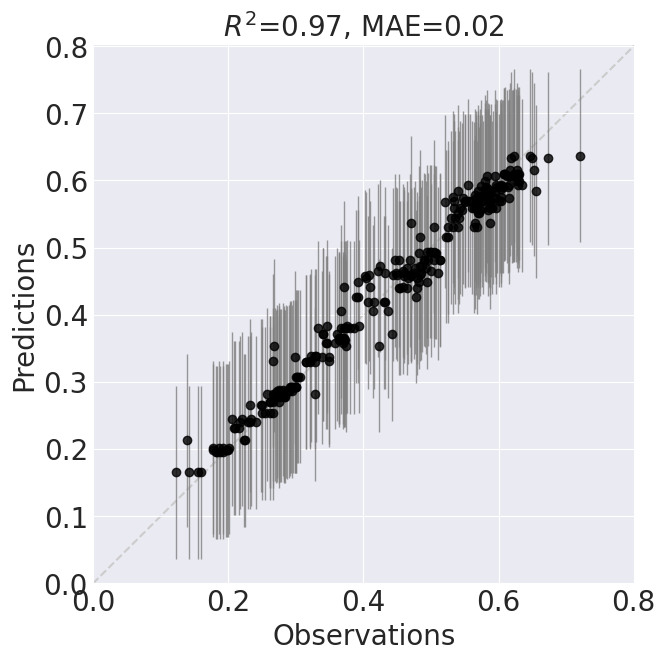

CPU times: user 5min 57s, sys: 4.77 s, total: 6min 1s
Wall time: 7min 38s


In [39]:
%%time
if run_art:
    art = RecommendationEngine(df_stacked, **art_params)
else:
    with open(os.path.join(art_params['output_dir'], 'art_4tpots.pkl'), 'rb') as output:
        art = pickle.load(output)

In [19]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.110699,32.846487,0.086274,0.019698,0.034496
Random Forest Regressor,0.053110,14.009833,0.042303,0.004610,0.774021
Support Vector Regressor,0.076062,21.542186,0.049603,0.008246,0.595817
Kernel Ridge Regressor,0.099094,23.685700,0.079295,0.016107,0.210469
K-NN Regressor,0.066459,19.116251,0.057176,0.007686,0.623266
Gaussian Process Regressor,0.065316,19.234135,0.062690,0.008196,0.598250
Gradient Boosting Regressor,0.052266,13.719539,0.038509,0.004215,0.793408
TPOT Regressor,0.062500,15.088341,0.050830,0.006490,0.681886
TPOT Regressor,0.057147,15.442914,0.046984,0.005473,0.731721


In [40]:
art.save_pkl_object()

#### Exploitation recommendations

In [41]:
art.niter = 100000
art.alpha = user_params['alpha_exploit']
art.num_recommendations = user_params['n_instances_exploit'] # 
art.rel_rec_distance = 2. # Default is 0.2
# At least one of the features in the recommendation must differ by this relative factor from any point in the training data and any previous recommendations
# Then pick the one with the best objective function value and add to the recommendations. Repeat the distance filtering above. 
# Stops when 7 recommendations are found.
# If it cannot find enough recommendations, it will decrease the distance by 0.80x and try again.


In [52]:
art.max_mcmc_cores = 4
art.verbose = 2

In [53]:
art.save_pkl_object()

In [54]:
run_art_rec = True

In [55]:
%%time
if run_art_rec:
    draws = art.parallel_tempering_opt()
    art.rel_rec_distance = 2. # Default is 0.2, change if needed
    art.recommend(draws)
else:
    art.recommendations = pd.read_csv(
        f"{art.outDir}/recommendations.csv",
        sep='\t',
        index_col=0 
    ) 
    

Starting parallel tempering using 4 chains…
Done with parallel tempering in 2010.85 s


/opt/conda/lib/python3.10/site-packages/art/core.py:1823: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(


,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340
0,0.047211,53.102436,0.141327,4.744163,0.063207,12.937174,0.858872,994.020716,0.000303,0.000827,0.004180,0.009479,0.000345,0.013328,0.644515
1,0.064467,60.764907,0.093385,4.092305,0.020897,12.703703,0.100441,661.333618,0.000485,0.000375,0.003571,0.001703,0.001379,0.043930,0.642475
2,0.054617,24.752822,0.183791,2.461077,0.044870,23.211887,1.209776,1494.036519,0.000365,0.001107,0.005033,0.004561,0.001016,0.016920,0.640366
3,0.064360,86.005151,0.194875,3.700097,0.009642,12.238383,0.813558,676.150301,0.000537,0.000728,0.002090,0.002433,0.001539,0.047926,0.638873
4,0.026862,163.621589,0.137024,3.396187,0.041642,8.890166,1.541324,1399.555024,0.000348,0.000988,0.003444,0.003778,0.000401,0.034990,0.637333
5,0.073580,100.843416,0.113605,5.574769,0.024692,29.145088,1.730482,502.028513,0.000536,0.000865,0.004872,0.003829,0.001008,0.019757,0.636546
6,0.055413,119.809698,0.215026,3.868189,0.055663,23.861636,1.356254,1994.940236,0.000529,0.000224,0.002389,0.011526,0.000946,0.043261,0.635863
7,0.065537,123.839478,0.197613,12.758901,0.067221,9.052297,2.317694,1362.145818,0.000469,0.000981,0.004624,0.011689,0.000389,0.049428,0.633775
8,0.057447,103.411670,0.149556,6.458651,0.024823,9.715857,1.977436,2052.705052,0.000325,0.001880,0.005891,0.003060,0.001453,0.035204,0.633541
9,0.025975,46.415162,0.181418,4.508644,0.055227,18.629028,1.846991,912.144957,0.000588,0.000779,0.003763,0.013705,0.001767,0.038446,0.632739


CPU times: user 1.01 s, sys: 60.5 ms, total: 1.07 s
Wall time: 33min 31s


In [27]:
orig_file_name = f"{art_params['output_directory']}/draws.txt"
new_file_name = f"{art_params['output_directory']}/draws_exploit.txt"
os.rename(orig_file_name, new_file_name)

In [56]:
art.recommendations

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340
0,0.047211,53.102436,0.141327,4.744163,0.063207,12.937174,0.858872,994.020716,0.000303,0.000827,0.004180,0.009479,0.000345,0.013328,0.644515
1,0.064467,60.764907,0.093385,4.092305,0.020897,12.703703,0.100441,661.333618,0.000485,0.000375,0.003571,0.001703,0.001379,0.043930,0.642475
2,0.054617,24.752822,0.183791,2.461077,0.044870,23.211887,1.209776,1494.036519,0.000365,0.001107,0.005033,0.004561,0.001016,0.016920,0.640366
3,0.064360,86.005151,0.194875,3.700097,0.009642,12.238383,0.813558,676.150301,0.000537,0.000728,0.002090,0.002433,0.001539,0.047926,0.638873
4,0.026862,163.621589,0.137024,3.396187,0.041642,8.890166,1.541324,1399.555024,0.000348,0.000988,0.003444,0.003778,0.000401,0.034990,0.637333
5,0.073580,100.843416,0.113605,5.574769,0.024692,29.145088,1.730482,502.028513,0.000536,0.000865,0.004872,0.003829,0.001008,0.019757,0.636546
6,0.055413,119.809698,0.215026,3.868189,0.055663,23.861636,1.356254,1994.940236,0.000529,0.000224,0.002389,0.011526,0.000946,0.043261,0.635863
7,0.065537,123.839478,0.197613,12.758901,0.067221,9.052297,2.317694,1362.145818,0.000469,0.000981,0.004624,0.011689,0.000389,0.049428,0.633775
8,0.057447,103.411670,0.149556,6.458651,0.024823,9.715857,1.977436,2052.705052,0.000325,0.001880,0.005891,0.003060,0.001453,0.035204,0.633541
9,0.025975,46.415162,0.181418,4.508644,0.055227,18.629028,1.846991,912.144957,0.000588,0.000779,0.003763,0.013705,0.001767,0.038446,0.632739


In [57]:
art.save_pkl_object()

In [58]:
df_rec_exploit = art.recommendations.iloc[:3, :].copy()

In [ ]:
df_rec_exploit.rename(columns={'OD340': 'OD340_pred'}, inplace=True)

predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_exploit.values[:, :-1]
        ) # posterior predictive statistics: mean and std

df_rec_exploit['OD340_std'] = predicted_std

df_rec_exploit['Label'] = 'exploitation'

In [ ]:
plot.draws_pc(art, draws, plot_scale_factor=100, plot_draws=True, plot_kde=False)


In [ ]:
plot.recommendations_pc(art, plot_scale_factor=100)


In [ ]:
plot.model_pairwise(art)

#### Exploration recommendations

In [33]:
%%time
art.niter = 100000
art.alpha = user_params['alpha_explor']
draws = art.parallel_tempering_opt()


Finished 2.00 percent in 8.985280 s Acceptance rate = 0.589Adding DE jump with weight 20
Finished 99.00 percent in 317.986091 s Acceptance rate = 0.414026
Run Complete
CPU times: user 5min 9s, sys: 1.6 s, total: 5min 10s
Wall time: 5min 21s


In [34]:
orig_file_name = f"{art_params['output_directory']}/draws.txt"
new_file_name = f"{art_params['output_directory']}/draws_explor.txt"
os.rename(orig_file_name, new_file_name)

In [35]:
art.num_recommendations = user_params['n_instances_explor']
art.rel_rec_distance = 3.
art.recommend(draws)

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340
0,0.026205,2.868647,3.063754,0.051305,8.628131,5.058487,390.089741,0.000030,0.000393,0.000282,0.003961,0.000835,0.404899
1,0.037669,0.800197,1.415873,0.084858,13.717068,1.459033,323.896805,0.000296,0.002085,0.000992,0.005032,0.000835,0.452337
2,0.000523,2.849896,5.943808,0.079905,8.446208,4.240846,367.255495,0.000123,0.002005,0.000048,0.003702,0.000835,0.408803
3,0.000705,2.224790,6.153711,0.097613,14.043278,4.794772,394.734535,0.000037,0.002773,0.000990,0.006802,0.000835,0.450592
4,0.003253,2.266566,6.438007,0.054262,9.212677,2.150364,404.691896,0.000010,0.002287,0.000066,0.001922,0.000835,0.429996
5,0.039067,2.582378,5.991768,0.078723,8.607087,4.521068,381.318487,0.000033,0.001623,0.000992,0.000209,0.000835,0.416583
6,0.032352,2.681768,6.293779,0.003636,13.057300,1.678010,433.346634,0.000258,0.002099,0.000391,0.007259,0.000835,0.430691
7,0.010556,2.601029,5.705683,0.082804,12.939917,3.939057,475.957694,0.000033,0.001986,0.000992,0.007573,0.000835,0.456518


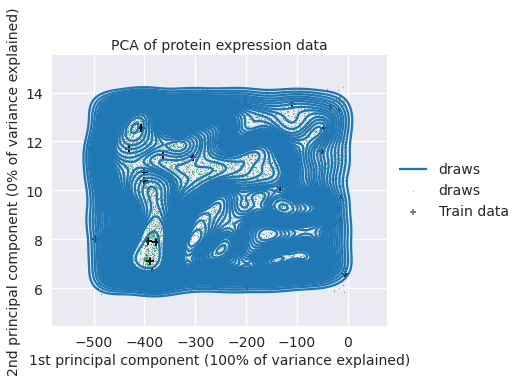

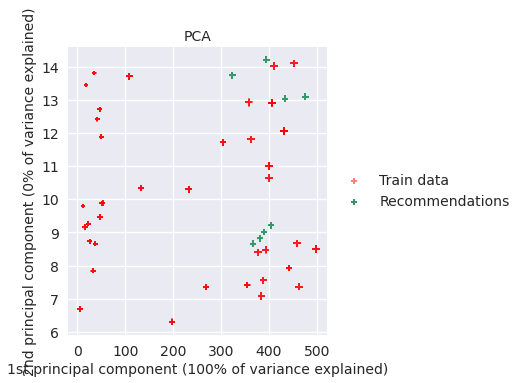

In [36]:
plot.draws_pc(art, draws, scale=100, plot_draws=True, plot_kde=True)
plot.recommendations_pc(art, scale=100)


In [37]:
df_rec_explor = art.recommendations.copy()


In [38]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_explor.values[:, :-1]
        )

df_rec_explor['OD340_std'] = predicted_std
df_rec_explor['Label'] = 'exploration'

In [39]:
df_rec = df_rec_exploit.append(df_rec_explor)

In [40]:
df_rec = df_rec.rename(columns={"OD340": "OD340_pred"})

Append to the target designs:

In [ ]:
df_target = df_target.append(df_rec).reset_index(drop=True)


In [ ]:
df_target.head()

### Generate the control media 

Read the standard recipe:

In [41]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

Control media will be uniformly drawn from the interval 90% to 110% around the standard recipe.

In [42]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
Control,0.003932,0.309966,1.206566,0.01076,9.146237,0.502864,52.253707,0.00003,0.000304,0.0001,0.000726,0.000098


Check that these controls are not equivalent to the controls tested in previous cycles:

In [43]:
for component in user_params['components']:
     assert(all(df_control.at['Control', component] != control_lines[component]))

Add ART's prediction for this design

In [44]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340_pred'] = control_predicted_mean
df_control['OD340_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [45]:
df_rec = df_rec.append(df_control).reset_index(drop=True)
df_rec

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340_pred,OD340_std,Label
0,0.024773,0.700826,4.06276,0.047732,12.929126,2.133702,414.274311,0.00025,0.001827,0.000484,0.004128,0.000014,0.578698,0.048176,exploitation
1,0.000956,2.184192,3.440721,0.091458,10.338878,2.814993,415.796644,0.000265,0.00029,0.000688,0.002765,0.000014,0.513430,0.048443,exploitation
2,0.00817,2.27814,5.092978,0.077865,11.739814,1.428153,411.076753,0.000279,0.000292,0.000689,0.003862,0.000014,0.511907,0.048315,exploitation
3,0.01828,2.206493,3.451213,0.059624,12.453609,0.332198,401.210566,0.000221,0.002911,0.00071,0.00435,0.000014,0.500242,0.048573,exploitation
4,0.014316,2.15443,2.710952,0.080738,10.910402,4.790117,456.776681,0.000184,0.000292,0.000689,0.001921,0.000014,0.497449,0.048050,exploitation
5,0.009734,2.242214,4.680379,0.056417,9.194358,1.921812,392.324374,0.000141,0.001184,0.000696,0.004599,0.000014,0.494262,0.047818,exploitation
6,0.033092,2.159783,3.831534,0.0665,9.140576,3.331034,469.248028,0.000276,0.001106,0.000486,0.000465,0.000014,0.490792,0.048198,exploitation
7,0.026205,2.868647,3.063754,0.051305,8.628131,5.058487,390.089741,0.00003,0.000393,0.000282,0.003961,0.000835,0.404899,0.049958,exploration
8,0.037669,0.800197,1.415873,0.084858,13.717068,1.459033,323.896805,0.000296,0.002085,0.000992,0.005032,0.000835,0.452337,0.049624,exploration
9,0.000523,2.849896,5.943808,0.079905,8.446208,4.240846,367.255495,0.000123,0.002005,0.000048,0.003702,0.000835,0.408803,0.049504,exploration


### Check the distribution of designs

Define dataframe with train data and predictions:

In [ ]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']

In [ ]:
df_train.head()

Add predictions, cv-predictions and standard deviation of the OD340 predictions for the train data:

In [ ]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )

In [ ]:
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]

Add label for control lines:

In [ ]:
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

In [ ]:
df_train.head()

Save train data set for this cycle:

In [ ]:
file = f"{user_params['output_file_path']}/train_pred.csv"
df_train.to_csv(file)

Append the control to the target designs:

In [ ]:
df_target = df_target.append(df_control).reset_index(drop=True)

Red are train data, green are recommendations, black are standards

In [ ]:
designs_pairwise(art, df_target, user_params, df_train)

In [ ]:
df_target.head()

In [ ]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_target.values[:, :-2]
        ) # posterior predictive statistics: mean and std

df_target['OD340_pred'] = predicted_mean
df_target['OD340_std'] = predicted_std
df_target.head()

## Saving the generated designs

Include all replicates: 

In [ ]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]


Rename index to well names:

In [ ]:
well_rows = 'ABCDEF'
well_columns = '12345678'

In [ ]:
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target.head()

In [ ]:
file = f"{user_params['output_file_path']}/target_concentrations.csv"
df_target.to_csv(file) # This file will be used for the computation of volume transfers and data analysis